# Hybrid Quantum Long-Short Term Memory NLP Example
The following example is adapted from the [official documentation](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) of pytorch, with the purpose of comparing the results of pytorch's classical LSTM and our hybrid quantum implementation.

In brief, starting from an input sequence $w_1$, ..., $w_i \in \mathcal{V}$ and a tag series $\{y_j\}_{j=1,...i} \in \mathcal{T}$, being $\mathcal{V}$ our vocabulary and $\mathcal{T}$ our tag set, the model outputs a prediction $\hat{y1}, ..., \hat{y_M} \in \mathcal{T}$ applying the following prediction rule

\begin{equation}
\hat{y_i} = argmax_{j} \ log \ Softmax(Ah_i + b)
\end{equation}

Please have a look at pytorch's official documentation for further details.

In [1]:
!pip install qlearnkit['pennylane']
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import qlearnkit as ql
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt


Let's first prepare our data

In [3]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index
ix_to_tag = {i: k for k, i in tag_to_ix.items()}


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Entities: {0: 'DET', 1: 'NN', 2: 'V'}


Now Let's create the Tagger model embedding our LSTM

In [4]:
class LSTMTagger(nn.Module):

    def __init__(self,
                 model,
                 embedding_dim,
                 hidden_dim,
                 vocab_size,
                 tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.model = model


        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.model(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

Let's set (by hand) some hyperparameters

In [5]:
embedding_dim = 8
hidden_dim = 6
n_layers = 1
n_qubits = 4
n_epochs = 300
device = 'default.qubit'

Let's also create an helper trainer that accepting our hyperparameters and a model, to simply call it with our two implementations

In [6]:
def trainer(lstm_model, embedding_dim, hidden_dim,
            n_epochs, model_label):
    # the LSTM Tagger Model
    model = LSTMTagger(lstm_model,
                   embedding_dim,
                   hidden_dim,
                   vocab_size=len(word_to_ix),
                   tagset_size=len(tag_to_ix))
    # loss function and Stochastic Gradient Descend
    # as optimizers
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))

            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)
        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)

        # print("preds", preds)
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0))
        history['acc'].append(accuracy)

        print(f"Epoch {epoch + 1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(history['loss'], label=f"{model_label} Loss")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(history['acc'], label=f"{model_label} LSTM Accuracy", color='tab:red')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.5)
    plt.legend(loc="upper right")

    plt.show()

Let's create our Quantum LSTM from qleanrkit

In [7]:
import qlearnkit.nn as qnn
qlstm = qnn.QLongShortTermMemory(
    embedding_dim,
    hidden_dim,
    n_layers,
    n_qubits=n_qubits,
    device=device
)

Let's have a look at its (quantum) architecture

**NOTICE:** ignore the following code per se, it has nothing to do with the actual usage of qlearnkit's QLSTM. It's just here to cope with the required parameters of `qml.draw`

In [8]:
# random values to feed into the QNode
inputs = torch.rand(embedding_dim, n_qubits)
weights = torch.rand(n_layers, n_qubits, 3)
import pennylane as qml
dev = qml.device(device, wires=n_qubits)
circ = qml.QNode(qlstm._construct_vqc, dev)

print(qml.draw(circ, expansion_strategy='device', show_all_wires=True)(inputs, weights))

 0: ──H──RY(M0)──RZ(M4)──╭C─────────────────────────────╭X──RX(0.642)──RY(0.351)──RZ(0.687)──┤ ⟨Z⟩ 
 1: ──H──RY(M1)──RZ(M5)──╰X──╭C───RX(0.138)──RY(0.664)──│───RZ(0.154)────────────────────────┤ ⟨Z⟩ 
 2: ──H──RY(M2)──RZ(M6)──────╰X──╭C──────────RX(0.493)──│───RY(0.593)──RZ(0.452)─────────────┤ ⟨Z⟩ 
 3: ──H──RY(M3)──RZ(M7)──────────╰X─────────────────────╰C──RX(0.968)──RY(0.899)──RZ(0.434)──┤ ⟨Z⟩ 
M0 =
tensor([0.4410, 0.2851, 0.0922, 0.2085, 0.4189, 0.5568, 0.3468, 0.4773])
M1 =
tensor([0.5397, 0.3276, 0.0610, 0.7491, 0.2016, 0.1892, 0.4293, 0.3255])
M2 =
tensor([0.5904, 0.5577, 0.2555, 0.6175, 0.4668, 0.4356, 0.3120, 0.4006])
M3 =
tensor([0.6520, 0.0839, 0.3924, 0.0972, 0.4129, 0.7706, 0.1809, 0.6805])
M4 =
tensor([0.2192, 0.0857, 0.0085, 0.0447, 0.1958, 0.3697, 0.1299, 0.2614])
M5 =
tensor([0.3446, 0.1150, 0.0037, 0.7129, 0.0418, 0.0367, 0.2065, 0.1134])
M6 =
tensor([0.4221, 0.3711, 0.0681, 0.4672, 0.2487, 0.2133, 0.1037, 0.1775])
M7 =
tensor([0.5277, 0.0071, 0.1696, 0.0095, 0.1896, 0

Now we can train our hybrid-quantum model

Epoch 1 / 300: Loss = 1.216 Acc = 0.22
Epoch 2 / 300: Loss = 1.183 Acc = 0.22
Epoch 3 / 300: Loss = 1.153 Acc = 0.22
Epoch 4 / 300: Loss = 1.126 Acc = 0.22
Epoch 5 / 300: Loss = 1.103 Acc = 0.22
Epoch 6 / 300: Loss = 1.082 Acc = 0.33
Epoch 7 / 300: Loss = 1.064 Acc = 0.44
Epoch 8 / 300: Loss = 1.048 Acc = 0.56
Epoch 9 / 300: Loss = 1.034 Acc = 0.78
Epoch 10 / 300: Loss = 1.021 Acc = 0.67
Epoch 11 / 300: Loss = 1.009 Acc = 0.67
Epoch 12 / 300: Loss = 0.998 Acc = 0.67
Epoch 13 / 300: Loss = 0.988 Acc = 0.67
Epoch 14 / 300: Loss = 0.978 Acc = 0.67
Epoch 15 / 300: Loss = 0.969 Acc = 0.67
Epoch 16 / 300: Loss = 0.959 Acc = 0.67
Epoch 17 / 300: Loss = 0.950 Acc = 0.67
Epoch 18 / 300: Loss = 0.940 Acc = 0.67
Epoch 19 / 300: Loss = 0.930 Acc = 0.67
Epoch 20 / 300: Loss = 0.918 Acc = 0.67
Epoch 21 / 300: Loss = 0.906 Acc = 0.67
Epoch 22 / 300: Loss = 0.893 Acc = 0.67
Epoch 23 / 300: Loss = 0.879 Acc = 0.67
Epoch 24 / 300: Loss = 0.865 Acc = 0.67
Epoch 25 / 300: Loss = 0.853 Acc = 0.78
Epoch 26 

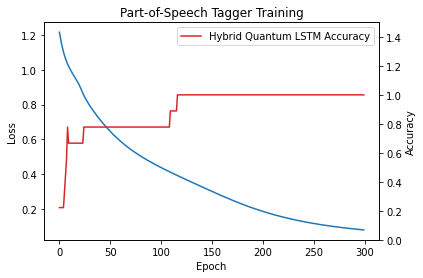

In [10]:
trainer(qlstm, embedding_dim, hidden_dim, n_epochs, model_label='Hybrid Quantum')

Let's compare it with the classical version

Epoch 1 / 300: Loss = 1.119 Acc = 0.33
Epoch 2 / 300: Loss = 1.108 Acc = 0.33
Epoch 3 / 300: Loss = 1.098 Acc = 0.33
Epoch 4 / 300: Loss = 1.089 Acc = 0.44
Epoch 5 / 300: Loss = 1.081 Acc = 0.44
Epoch 6 / 300: Loss = 1.073 Acc = 0.44
Epoch 7 / 300: Loss = 1.067 Acc = 0.44
Epoch 8 / 300: Loss = 1.061 Acc = 0.44
Epoch 9 / 300: Loss = 1.055 Acc = 0.44
Epoch 10 / 300: Loss = 1.051 Acc = 0.44
Epoch 11 / 300: Loss = 1.046 Acc = 0.44
Epoch 12 / 300: Loss = 1.042 Acc = 0.56
Epoch 13 / 300: Loss = 1.038 Acc = 0.44
Epoch 14 / 300: Loss = 1.034 Acc = 0.44
Epoch 15 / 300: Loss = 1.031 Acc = 0.44
Epoch 16 / 300: Loss = 1.028 Acc = 0.44
Epoch 17 / 300: Loss = 1.025 Acc = 0.44
Epoch 18 / 300: Loss = 1.022 Acc = 0.44
Epoch 19 / 300: Loss = 1.019 Acc = 0.44
Epoch 20 / 300: Loss = 1.016 Acc = 0.44
Epoch 21 / 300: Loss = 1.013 Acc = 0.44
Epoch 22 / 300: Loss = 1.011 Acc = 0.44
Epoch 23 / 300: Loss = 1.008 Acc = 0.44
Epoch 24 / 300: Loss = 1.005 Acc = 0.44
Epoch 25 / 300: Loss = 1.003 Acc = 0.44
Epoch 26 

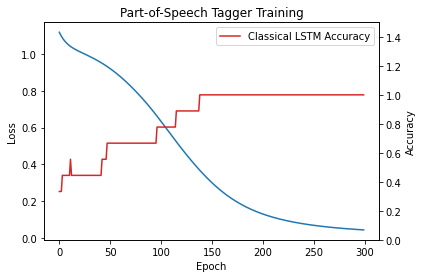

In [11]:
clstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers)
trainer(clstm, embedding_dim, hidden_dim, n_epochs,model_label='Classical')

In case you want to try with a different backend simulator you could also install `pennylane-qiskit` and play around with `qiskit.aer` or `qiskit.qasm`.

Be aware that it's going to be way slower because of qiskit simulators.